In [1]:
import colorsys
import random
import numpy as np
import IPython
import cv2
import base64
import io
import torch 
import torchvision
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    # mask is (480, 640), image (480, 640, 3)
    # image = np.asarray(image)
    mask = np.asarray(mask)
    # image.setflags(write=1)
    # print(image.shape, mask.shape)
    image_c = np.zeros(shape = image.shape)
    for c in range(3):
        image_c[:,:,c] = np.where(mask > 200, image[:,:,c] * (1-alpha) + alpha * color[c] * mask, image[:,:,c])

    return image_c


def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_encoded_image(file):
    with open(file, 'rb') as image:
        f = base64.b64encode(image.read())
    return f

def get_decoded_image(fstr):
    image = base64.b64decode(fstr)
    return Image.open(io.BytesIO(image)).convert('RGB')

def get_prediction(encoded_image):
    dec = get_decoded_image(encoded_image)
    img = transforms.ToTensor()(dec)
    
    model = get_instance_segmentation_model(2)
    model.load_state_dict(torch.load('/home/locobotm/model1.pt'))
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        orig = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
        
        thresh = 0.8
        N = prediction[0]['boxes'].shape[0]
        colors = random_colors(N)
        masks = orig.copy() 
        masked_image = np.asarray(orig)
        # print("type {}, size {}, mode {}".format(type(masks), masks.size, masks.mode))
        for i in range(N):
            color = colors[i]
            if prediction[0]['scores'][i] > thresh:
              mask = Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy())
              masked_image = apply_mask(masked_image, mask.copy(), color)
        
        masked = Image.fromarray(masked_image.astype('uint8'), 'RGB')
    
    return masked

In [2]:
file = '/home/locobotm/data/images2/botcapture_5V0nOt.jpg'



In [3]:
en = get_encoded_image(file)

In [4]:
dec = get_decoded_image(en)
print(type(dec), dec.size, dec.mode)

<class 'PIL.Image.Image'> (640, 480) RGB


In [5]:
# dec.show()

In [6]:
ret = get_prediction(en)
print(type(ret), ret.size)

<class 'PIL.Image.Image'> (640, 480)


<class 'numpy.ndarray'> (480, 640, 3)


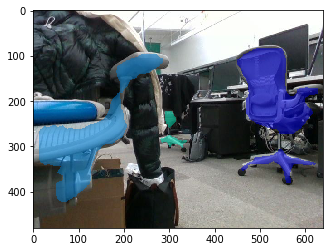

In [9]:
ocv = cv2.cvtColor(np.array(ret), cv2.COLOR_RGB2BGR)
print(type(ocv), ocv.shape)
# cv2.imshow('ret', ocv)
plt.imshow(ocv)